In [ ]:
# %% load packages
import locale
import sys
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import optuna
import requests
import torch
import random
from sqlalchemy import create_engine,inspect
from pathlib import Path
import urllib.parse
import pyarrow
from calendar import day_abbr
import calendar
from typing import Tuple, Union, Dict, List
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

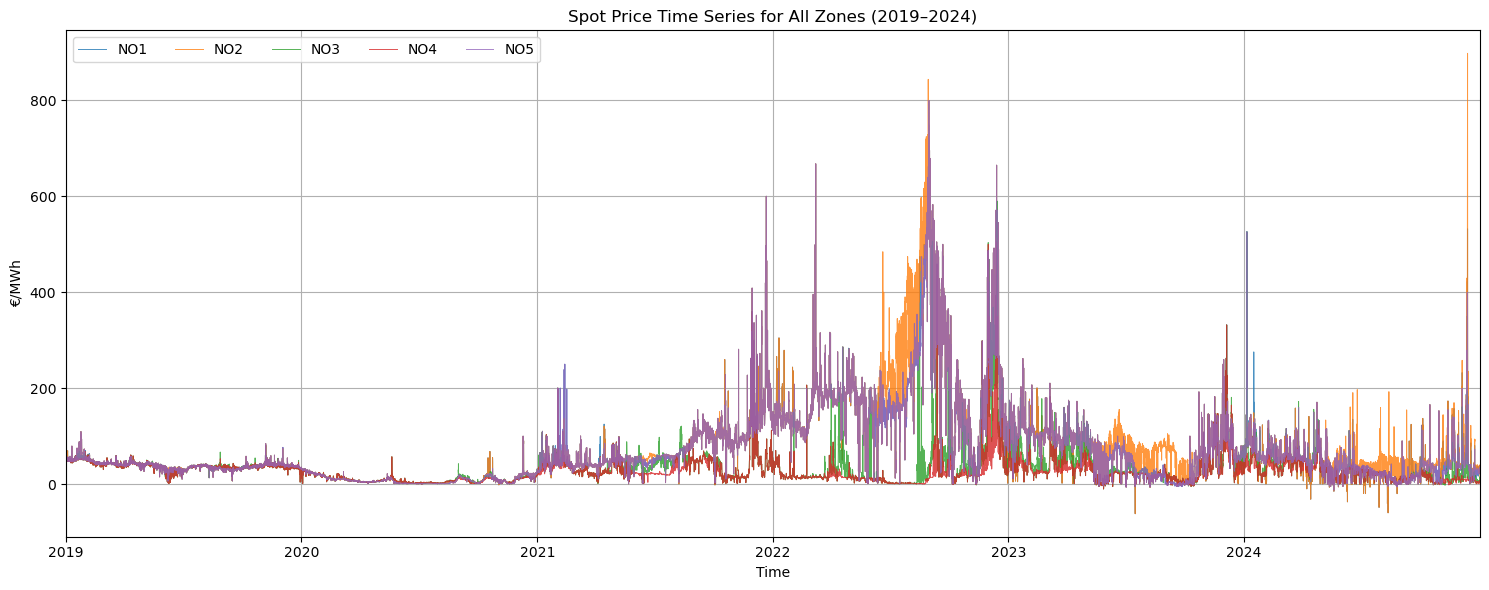

In [29]:
# Price Time Series for All Zones (2019–2024)

# Load 5 zones
folder = Path.cwd().parents[1] / "data"
mapcodes = ["NO1", "NO2", "NO3", "NO4", "NO5"]

frames = []
for z in mapcodes:
    f = folder / f"data_{z.lower()}.csv"
    df = pd.read_csv(f, parse_dates=["time_utc"])
    df["MapCode"] = z               
    frames.append(df)

df_all = pd.concat(frames, ignore_index=True)
df_all["hour"] = df_all["time_utc"].dt.hour

# time series plot
fig, ax = plt.subplots(figsize=(15,6))

for z in mapcodes:
    sub = df_all[df_all["MapCode"] == z].copy()
    sub = sub.sort_values("time_utc")
    ax.plot(sub["time_utc"], sub["Price"], label=z, lw=0.7, alpha=0.8)

ax.set_xlabel("Time")
ax.set_ylabel("€/MWh")
ax.set_title("Spot Price Time Series for All Zones (2019–2024)")
ax.legend(ncol=5)
ax.grid(True)

min_time = df_all["time_utc"].min()
max_time = df_all["time_utc"].max()
ax.set_xlim([min_time, max_time])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()


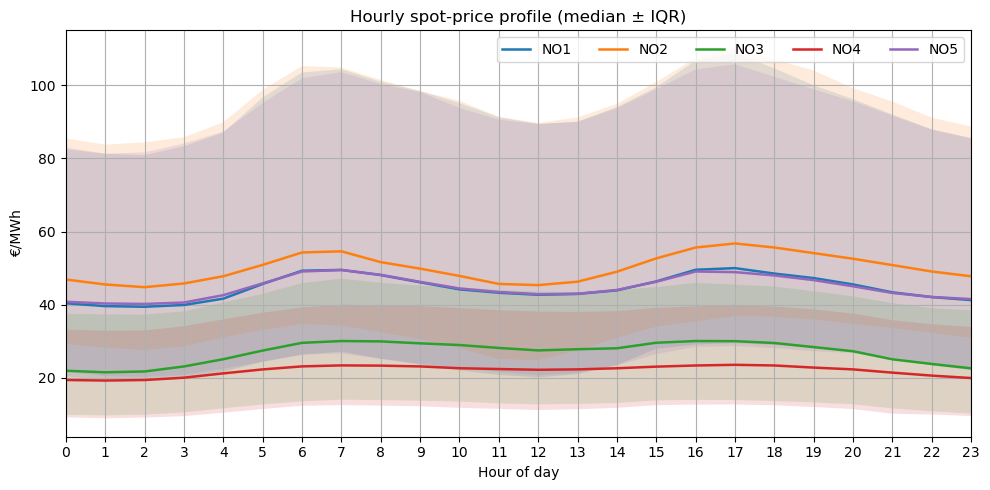

In [ ]:
# Hourly profile ribbon

# Load 5 zones
folder = Path.cwd().parents[1] / "data"
mapcodes = ["NO1", "NO2", "NO3", "NO4", "NO5"]

frames = []
for z in mapcodes:
    f = folder / f"data_{z.lower()}.csv"
    df = pd.read_csv(f, parse_dates=["time_utc"])
    df["MapCode"] = z               
    frames.append(df)

df_all = pd.concat(frames, ignore_index=True)
df_all["hour"] = df_all["time_utc"].dt.hour

# Hourly price with IQR per zone
fig, ax = plt.subplots(figsize=(10,5))

for z in mapcodes:
    sub = df_all[df_all["MapCode"] == z]
    grp = sub.groupby("hour")["Price"]
    med = grp.median()
    p25 = grp.quantile(0.25)
    p75 = grp.quantile(0.75)

    ax.plot(med.index, med.values, label=z, lw=1.8)
    ax.fill_between(med.index, p25.values, p75.values, alpha=0.15)

ax.set_xlabel("Hour of day")
ax.set_ylabel("€/MWh")
ax.set_title("Hourly spot-price profile (median ± IQR)")
ax.legend(ncol=5)
ax.grid(True)
ax.set_xticks(range(24))
ax.set_xlim(0,23)
plt.tight_layout()
plt.show()

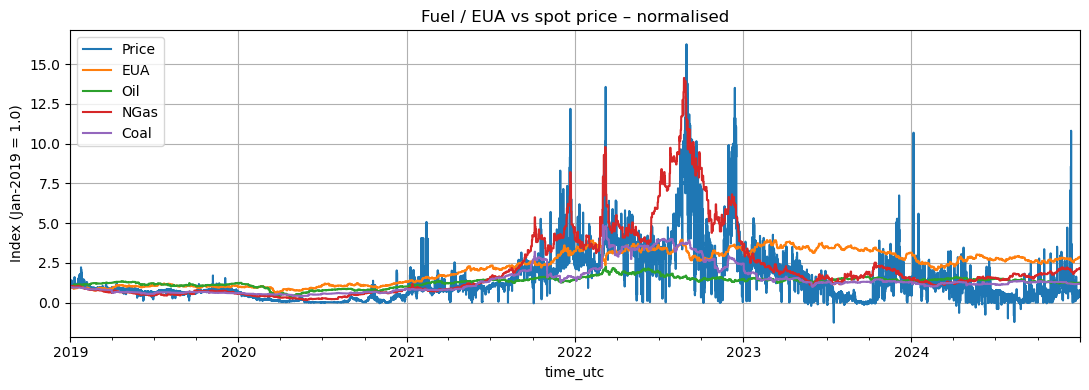

In [ ]:
# Fuel-price alignment (NO1 as reference). Changing zone will change baseline norm. term and hence values for fule columns!

# Choose one zone – NO1 – for the spot series
spot = df_all[df_all["MapCode"]=="NO1"][["time_utc","Price"]].drop_duplicates("time_utc")

# Fuel / EUA columns 
fuel_cols = ["EUA", "Oil", "NGas", "Coal"]    

fuels = (
    df_all.drop_duplicates("time_utc")[["time_utc"] + fuel_cols]
    .set_index("time_utc")
)

series = spot.set_index("time_utc").join(fuels)
baseline = series.loc["2019-01"].iloc[0]            # baseline normalisation
normed   = series / baseline

fig, ax = plt.subplots(figsize=(11,4))
normed.plot(ax=ax)
ax.set_ylabel("Index (Jan-2019 = 1.0)")
ax.set_title("Fuel / EUA vs spot price – normalised")
ax.grid(True)
plt.tight_layout()
plt.show()
